In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
df2 = pd.read_csv('Second_dataset_rul.csv').drop(['Unnamed: 0'], axis=1)
df2 = df2.sort_values('timestamp')
df2.head()
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2
train_2 = df2[df2["timestamp"]<"2018-04-21 00:00:00"]
cali_2 = df2[(df2["timestamp"]>="2018-04-21 00:00:00")&(df2["timestamp"]<="2018-04-26 00:00:00")]
test_2 = df2[df2["timestamp"]>="2018-04-26 00:00:00"]
train_2 = train_2[:15000]
cali_2 = cali_2[:5000]
test_2 = test_2[:5000]

In [3]:
test = test_2.drop('timestamp', axis=1)
train = train_2.drop('timestamp', axis=1)
cal = cali_2.drop('timestamp', axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train = train.drop('rul', axis=1)
y_train = train['rul']
X_test = test.drop('rul', axis=1)
y_test = test['rul']
X_cal = cal.drop('rul', axis=1)
y_cal = cal['rul']

print(X_train.shape)
print(X_test.shape)
print(X_cal.shape)

(15000, 50)
(5000, 50)
(5000, 50)


In [5]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree(X_train, y_train, X_test):
  dt = DecisionTreeRegressor(max_depth=5)
  model = dt.fit(X_train, y_train)

  y_pred = dt.predict(X_test)

  return model, y_pred

In [6]:
from sklearn.ensemble import GradientBoostingRegressor

def gradient_boost(X_train, y_train, X_test):
  gb = GradientBoostingRegressor(max_depth=5)
  model = gb.fit(X_train, y_train)

  y_pred = gb.predict(X_test)

  return model, y_pred

In [7]:
from mapie.regression import MapieRegressor  #partialfit

def conformal_prediction(model, a, X_train, y_train, X_test):
  mapie = MapieRegressor(estimator=model)
  mapie_reg = mapie.fit(X_train, y_train)
  y_pred, y_pis = mapie_reg.predict(X_test, alpha=a)

  return y_pred, y_pis

In [8]:
import matplotlib.pyplot as plt

def plot_without_cp(y_test, y_pred):
  x = np.arange(1,len(y_pred)+1)

  plt.figure(figsize=(18,6))

  plt.plot(x[0:500],y_pred[0:500])
  plt.plot(x[0:500],y_test[0:500])
  plt.xlabel('First 100th sample')
  plt.ylabel('RUL')
  plt.title('Predictive maintenance RUL of first 100 samples')
  plt.legend(["prediction","true"])
  plt.grid(True)
  plt.show()

In [9]:
def plot_with_cp(y_test, y_pred, y_pis, confidence):
  x = np.arange(1,len(y_pred)+1)

  plt.figure(figsize=(18,6))

  plt.plot(x[0:500],y_pred[0:500])
  plt.plot(x[0:500],y_test[0:500])

  #plt.plot(x[0:100],y_pis[:,0][0:100])
  #plt.plot(x[0:100],y_pis[:,1][0:100])

  plt.fill_between(x[0:500], y_pis[:,0][0:500].flatten(), y_pis[:,1][0:500].flatten(), alpha=0.2, color='tab:green')

  plt.xlabel('First 100 sample')
  plt.ylabel('RUL')
  plt.title('Predictive maintenance RUL of first 500th samples with confidence of ' + confidence +'%')
  plt.legend(["prediction","true",confidence + "% confidence interval"])
  plt.grid(True)
  plt.show()

In [10]:
dt_model, y_pred = decision_tree(X_train, y_train, X_test)

In [11]:
y_pred_dt, y_pis_dt = conformal_prediction(dt_model,0.1, X_cal, y_cal, X_test)

In [12]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_dt)

-16.747309427215807

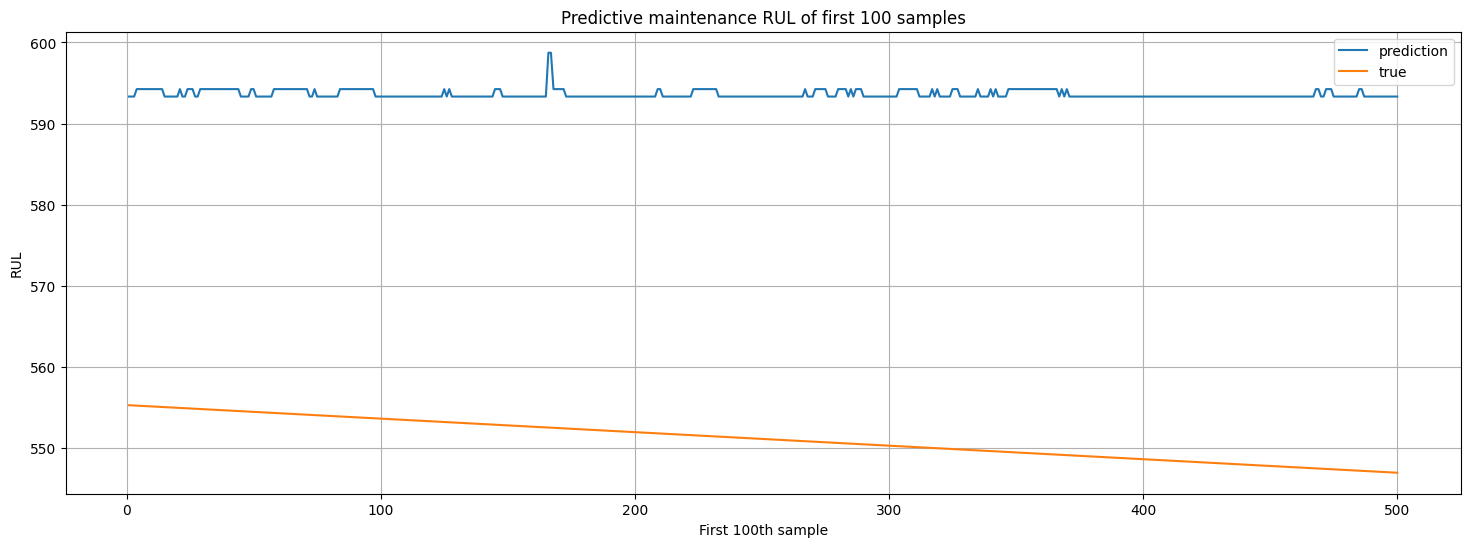

In [15]:
plot_without_cp(y_test, y_pred_dt)

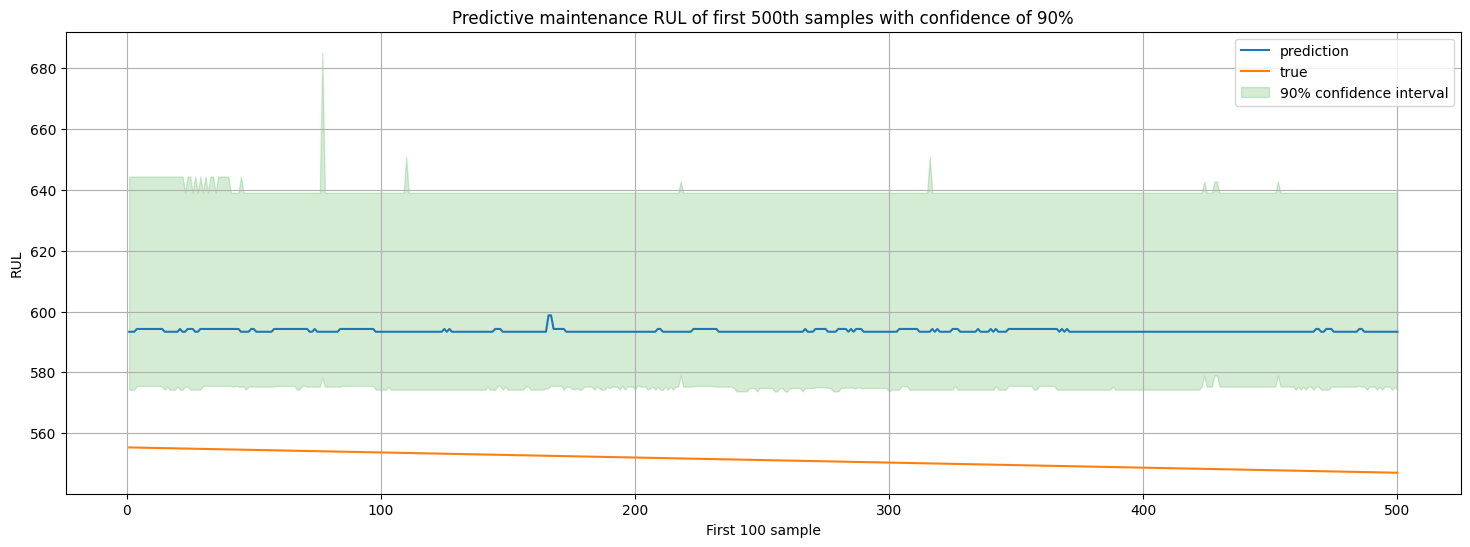

In [16]:
plot_with_cp(y_test, y_pred_dt, y_pis_dt, "90")

In [17]:
gb_model, y_pred = gradient_boost(X_train, y_train, X_test)


In [18]:
y_pred_gb, y_pis_gb = conformal_prediction(gb_model,0.1, X_cal, y_cal, X_test)

In [19]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_gb)

-16.1630627447192

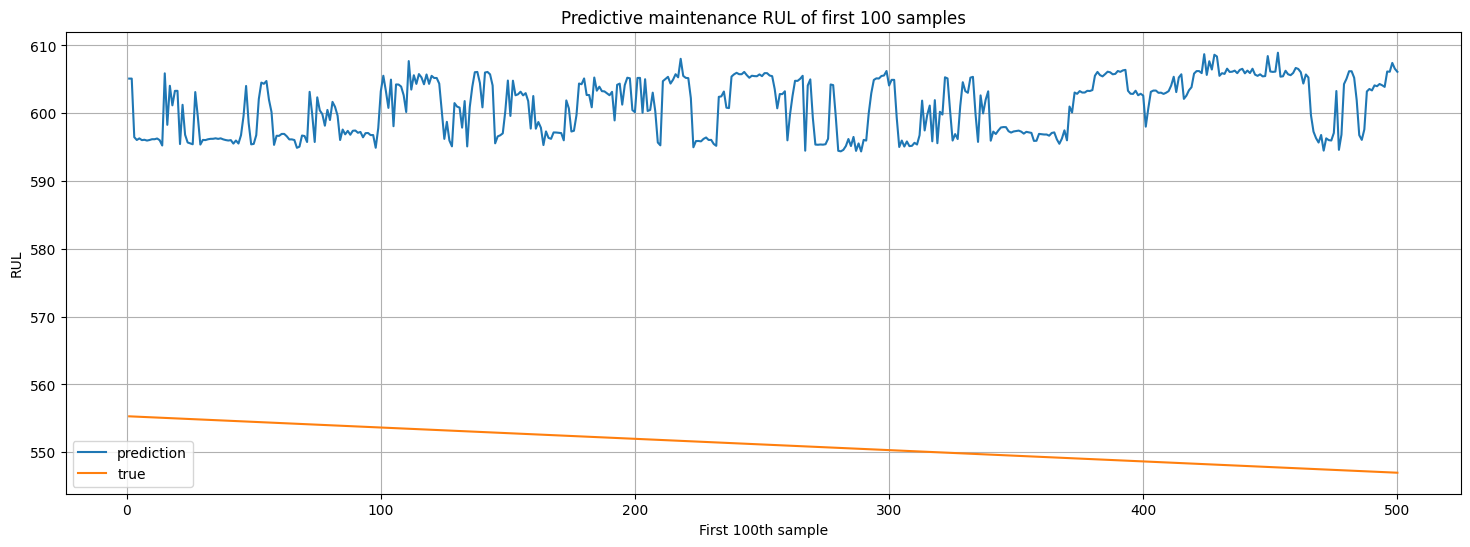

In [20]:
plot_without_cp(y_test, y_pred_gb)

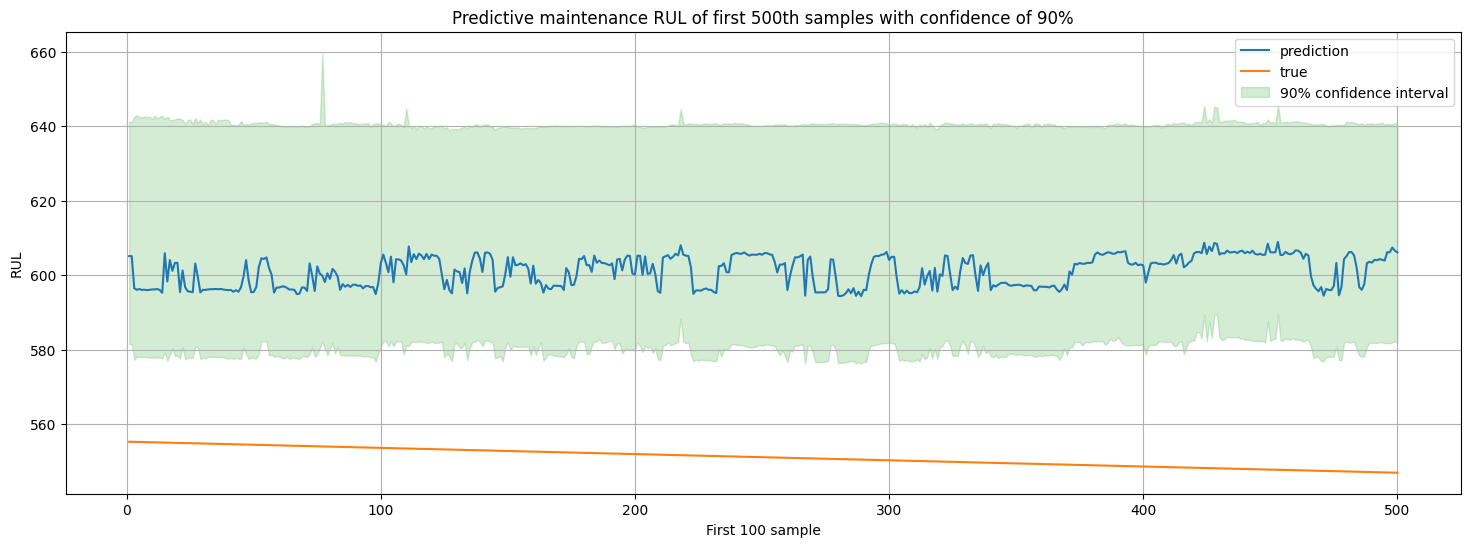

In [21]:
plot_with_cp(y_test, y_pred_gb, y_pis_gb, "90")

### 2nd Dataset 

In [23]:
df2 = pd.read_csv('rul_hrs.csv')#.drop(['Unnamed: 0', 'timestamp'], axis=1)
df2[['Dust']] = df2[['Dust']].apply(lambda x: pd.factorize(x)[0])
X = df2.drop('RUL', axis=1)
y = df2['RUL']
df2.head()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.271267,52.281993,0.1,236.428943,0,58.9
1,1,0.361690,54.986671,0.2,236.428943,0,58.8
2,1,0.000000,55.424786,0.3,236.428943,0,58.7
3,1,2.622251,55.524146,0.4,236.428943,0,58.6
4,1,3.888165,55.852018,0.5,236.428943,0,58.5


In [26]:

train = df2[df2["Data_No"]<=40]
calibration = df2[(df2["Data_No"]>40)&(df2["Data_No"]<=45)]
test = df2[df2["Data_No"]>45]

In [27]:
train.head()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.271267,52.281993,0.1,236.428943,0,58.9
1,1,0.361690,54.986671,0.2,236.428943,0,58.8
2,1,0.000000,55.424786,0.3,236.428943,0,58.7
3,1,2.622251,55.524146,0.4,236.428943,0,58.6
4,1,3.888165,55.852018,0.5,236.428943,0,58.5


In [28]:
X_train = train[["Data_No", "Differential_pressure", "Flow_rate",	"Dust_feed"]]
y_train = train["RUL"]

In [29]:
X_cali = calibration[["Data_No", "Differential_pressure", "Flow_rate",	"Dust_feed"]]
y_cali = calibration["RUL"]

In [30]:
X_test = test[["Data_No", "Differential_pressure", "Flow_rate",	"Dust_feed"]]
y_test = test["RUL"]

In [31]:
dt_model, y_pred = decision_tree(X_train, y_train, X_test)

In [33]:
y_pred_dt, y_pis_dt = conformal_prediction(dt_model,0.1, X_cali, y_cali, X_test)

In [34]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_dt)

-1.0536109197378956

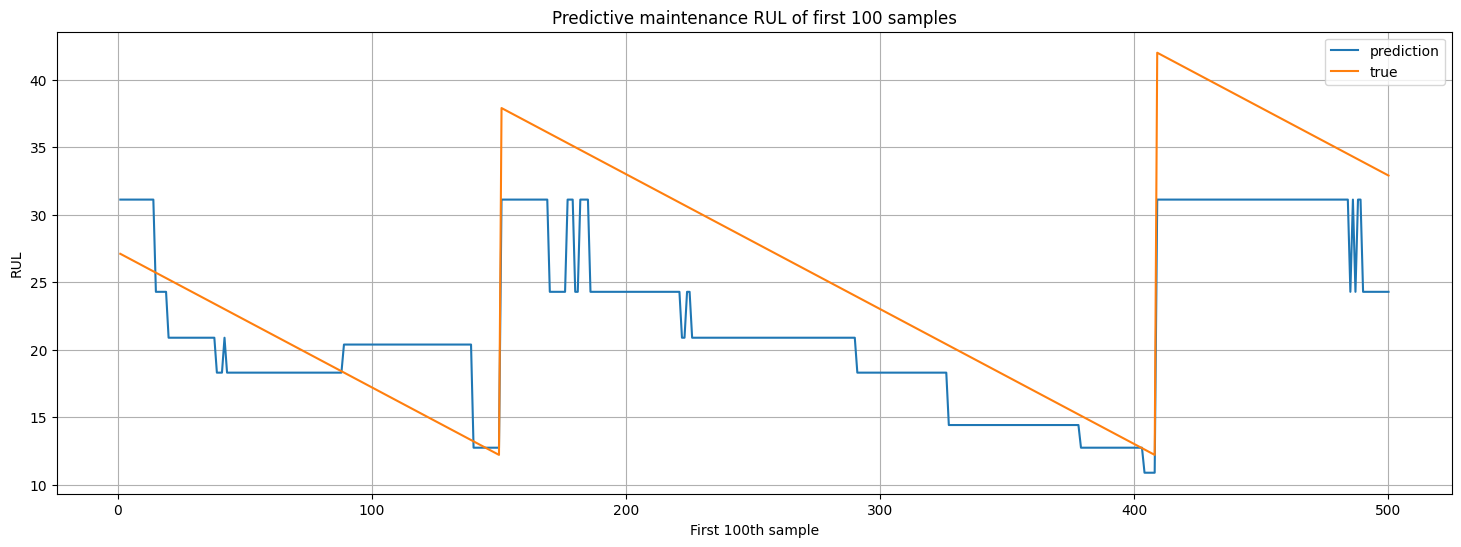

In [35]:
plot_without_cp(y_test, y_pred_dt)


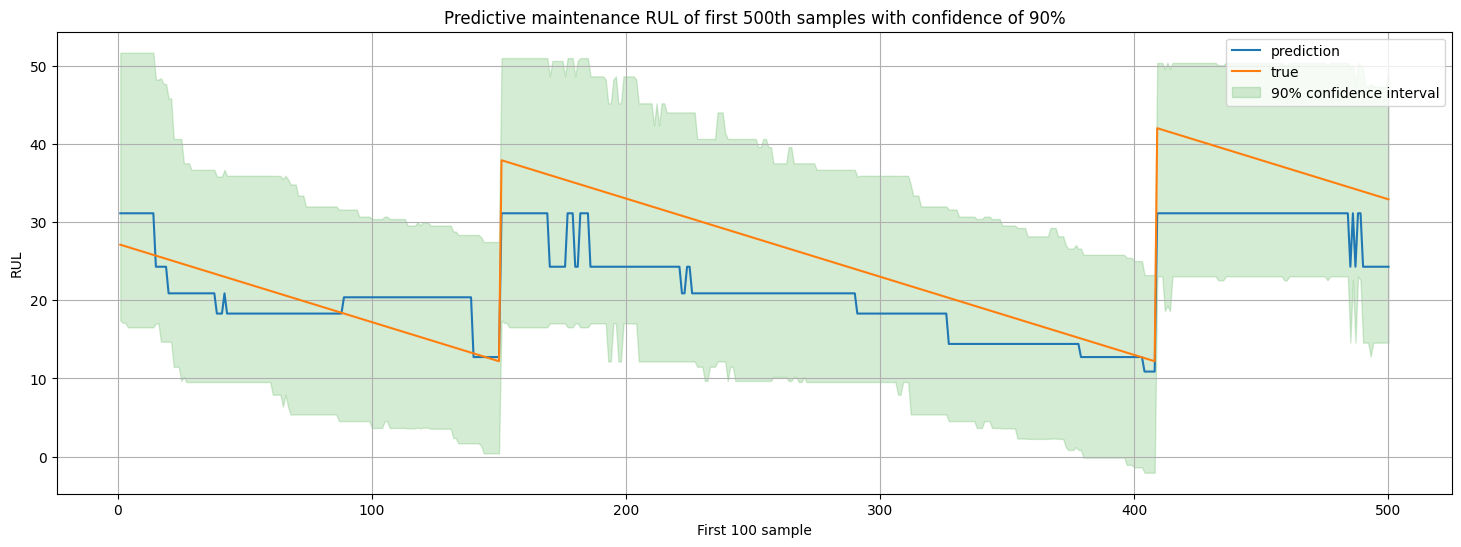

In [36]:
plot_with_cp(y_test, y_pred_dt, y_pis_dt, "90")

In [37]:
gb_model, y_pred = gradient_boost(X_train, y_train, X_test)

In [38]:
y_pred_gb, y_pis_gb = conformal_prediction(gb_model,0.1, X_cali, y_cali, X_test)

In [39]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_gb)

-1.0126748678845794

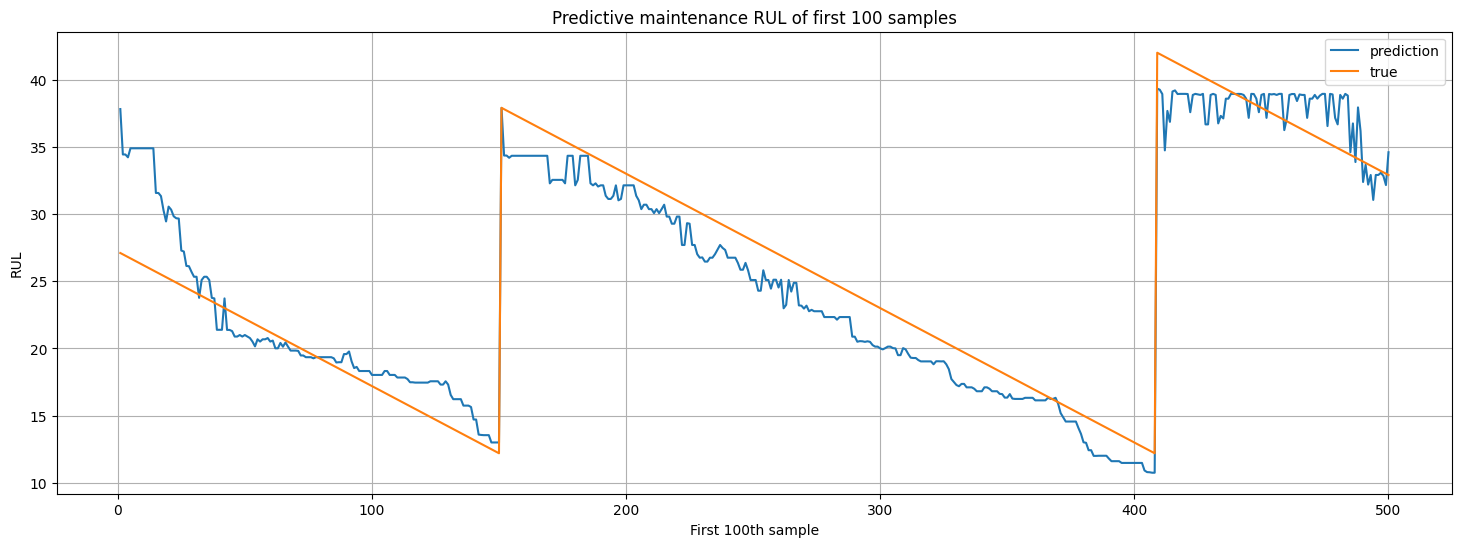

In [40]:
plot_without_cp(y_test, y_pred_gb)

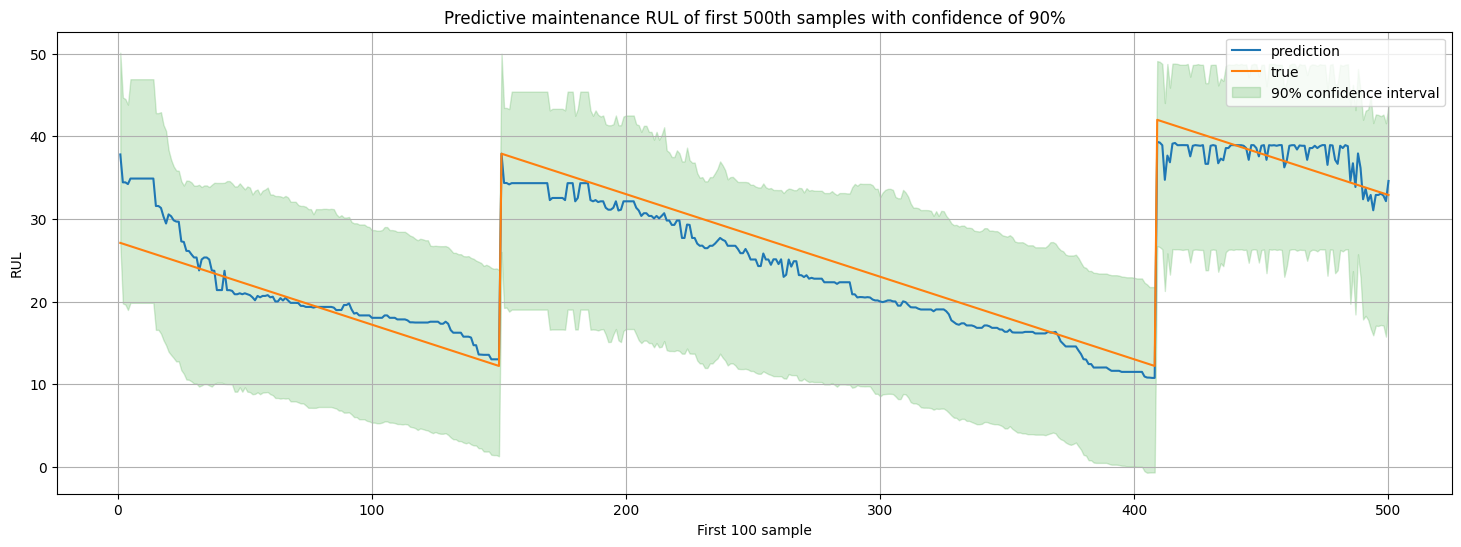

In [41]:
plot_with_cp(y_test, y_pred_gb, y_pis_gb, "90")

# LSTM

In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [ ]:
# df2 = pd.read_csv('Second_dataset_rul.csv').drop(['Unnamed: 0'], axis=1)
# df2 = df2[:5000]
# X = df2.drop('rul', axis=1)
# y = df2['rul']
# df2.head()

df2 = pd.read_csv('Second_dataset_rul.csv').drop(['Unnamed: 0'], axis=1)
df2 =  df2[:50000]
df2 = df2.sort_values('timestamp')
# X = df2.drop('rul', axis=1)
# y = df2['rul']
df2.head()
df2 = df2.drop('timestamp', axis=1)

In [ ]:
train_data, test_data = train_test_split(df2, test_size=0.2, shuffle=False) #random_state=42, stratify=df2['rul'])

In [ ]:
test_data.shape
train_data.shape

(40000, 51)

In [ ]:
features_col_name = df2.columns[:-1]
target_col_name = df2.columns[-1]

In [ ]:
X_train = train_data.copy()
X_test = test_data.copy()

In [ ]:
X_train.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,rul
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,285.916667
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,285.900000
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,285.883333
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,285.866667
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,285.850000


In [ ]:
sc=MinMaxScaler()
X_train[features_col_name] = sc.fit_transform(X_train[features_col_name])
X_test[features_col_name] = sc.transform(X_test[features_col_name])

In [ ]:
#function for features
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length,id_df.shape[1])), columns=id_df.columns)
    # id_df=df_zeros.append(id_df,ignore_index=True)
    id_df = pd.concat([df_zeros, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length,id_df.shape[1])), columns= id_df.columns)
    # id_df=df_zeros.append(id_df,ignore_index=True)
    id_df = pd.concat([df_zeros, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [ ]:
# timestamp or window size
seq_length=50
seq_cols=features_col_name

In [ ]:
X_Train=gen_sequence(X_train, seq_length, seq_cols)
print(X_Train.shape)
# generate y_train
y_train=gen_label(X_train, seq_length, seq_cols, label='rul')
print(y_train.shape)

(40000, 50, 50)
(40000,)


In [ ]:
X_Test=gen_sequence(X_test, seq_length, seq_cols)
print(X_Test.shape)
# generate y_train
y_test=gen_label(X_test, 50, seq_cols,'rul')
print(y_test.shape)

(10000, 50, 50)
(10000,)


In [ ]:
# # nb_features =X_Train.shape[2]
# # timestamp=seq_length

# # model = Sequential()

# # model.add(LSTM(
# #          input_shape=(timestamp, nb_features),
# #          units=100,
# #          return_sequences=True))
# # model.add(Dropout(0.5))

# # model.add(LSTM(
# #           units=50,
# #           return_sequences=False))
# # model.add(Dropout(0.5))

# # model.add(Dense(units=1, activation='softmax'))
# # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # model.summary()


# # # model = Sequential()
# # # model.add(LSTM(64,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[-1])))
# # # model.add(Dropout(0.5))
# # # model.add(LSTM(20,return_sequences=False))
# # # model.add(Dropout(0.5))
# # # model.add(Dense(1))
# # # model.compile(loss='mse', optimizer='rmsprop')

# nb_features =X_Train.shape[2]
# timestamp=seq_length

# model = Sequential()

# model.add(LSTM(
#          input_shape=(timestamp, nb_features),
#          units=100,
#          return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(
#           units=50,
#           return_sequences=False))
# model.add(Dropout(0.2))

# model.add(Dense(units=1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import math

def scheduler(epoch, lr):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr


In [ ]:
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (X_Train.shape[1], X_Train.shape[2]), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(X_Train, y_train, epochs = 10,
                    validation_data = (X_Test, y_test),
                    callbacks = callback,
                    batch_size = 128, verbose = 2)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
313/313 - 66s - loss: 81373.5469 - val_loss: 10561.3994 - lr: 0.0010 - 66s/epoch - 209ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
313/313 - 59s - loss: 65355.0078 - val_loss: 12485.5020 - lr: 0.0010 - 59s/epoch - 187ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
313/313 - 63s - loss: 65352.9219 - val_loss: 9712.6836 - lr: 0.0010 - 63s/epoch - 202ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
313/313 - 72s - loss: 47963.9453 - val_loss: 33939.6406 - lr: 0.0010 - 72s/epoch - 229ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
313/313 - 68s - loss: 12948.9238 - val_loss: 41331.1016 - lr: 0.0010 - 68s/epoch - 219ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/10
313/313 - 73s - loss: 10627.7803 - val_loss: 42392.9258 - lr: 0.0010 - 73s/epoch 

In [ ]:
# from sklearn import mean_squared_error
rul_pred = model.predict(X_Test)#.reshape(-1)
# preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
# mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
#                              for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
# RMSE = np.sqrt(mean_squared_error(y_test, mean_pred_for_each_engine))
# print("RMSE: ", RMSE)

313/313 [==============================] - 10s 29ms/step


In [ ]:
from keras.backend import sqrt
from keras.losses import mean_squared_error

y_pred = model.predict(X_Test)

# Calculate the mean squared error
mse = (mean_squared_error(y_test, y_pred))

# Calculate the RMSE
rmse = sqrt(mse)

print("Root Mean Squared Error (RMSE): {}".format(np.average(rmse)))


313/313 [==============================] - 11s 36ms/step
Root Mean Squared Error (RMSE): 168.3292999267578


In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))



s_score = compute_s_score(y_test, y_pred)
print("S-score: ", s_score)

S-score:  4.668263717289057e+21


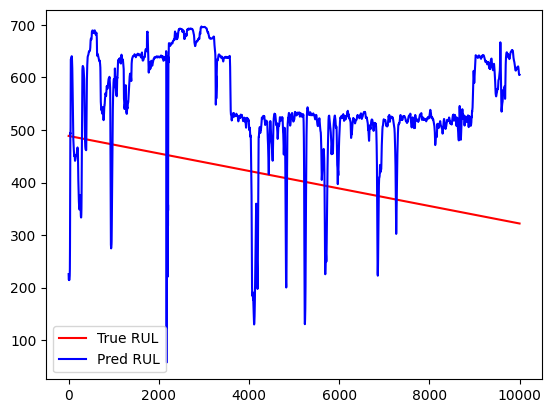

In [ ]:
# Plot true and predicted RUL values
plt.plot(y_test, label = "True RUL", color = "red")
plt.plot(y_pred, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [ ]:
X_Test.shape

(10000, 50, 50)